BSD 3-Clause License

Copyright (c) 2025, Pranjal Choudhury

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tifffile import tifffile
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

In [25]:
def standardize_images(data):
    processed_data = np.zeros_like(data)
    for i in range(data.shape[0]):
        image = data[i]
        # Step 1: Threshold - set pixels below 33% of the maximum to 0
        threshold_value = 0.33 * image.max()
        image = np.where(image < threshold_value,0, image)
        # Step 2: Normalize - scale pixel values to the range [0, 1]
        if image.max() > 0:
            normalized_image = image / image.max()
        else:
            normalized_image = image  # If max is 0, keep as is (all zeros)
        processed_data[i] = normalized_image
    return processed_data

def process_images(data):
    if len(data.shape)==2:
        processed_images = np.expand_dims(data, axis = 0)
        standardized_images = standardize_images(processed_images)
    elif len(data.shape)==3:
        standardized_images = standardize_images(data)
    else:
        print('incorrect image format')

    standardized_images=np.expand_dims(standardized_images, axis=-1)

    return standardized_images

In [26]:
# Define the residual block
def residual_block(x, filters, kernel_size=(3, 3), stride=(1, 1)):
    shortcut = x
    # First convolution
    x = layers.Conv2D(filters, kernel_size, padding='same', strides=stride)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Second convolution
    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Adjust shortcut if dimensions do not match
    if shortcut.shape[-1] != filters:  # Check if channel dimensions differ
        shortcut = layers.Conv2D(filters, (1, 1), padding='same')(shortcut)

    # Add skip connection
    x = layers.add([x, shortcut])  # Add the shortcut to the main path
    x = layers.Activation('relu')(x)  # Final activation
    return x

# Build the ResNet model
def build_resnet_model(input_data_shape, output_data_shape):
    inputs = layers.Input(shape=input_data_shape)

    # Initial Conv Layer
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)

    # Residual Blocks
    x = residual_block(x, 32)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)

    x = residual_block(x, 64)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and output layer
    x = layers.Flatten()(x)
    outputs = layers.Dense(output_data_shape, activation='linear')(x)

    model = models.Model(inputs, outputs)
    return model

In [10]:
data = tifffile.imread('training_5500.tif')
target = np.load('training_5500.npy')

In [11]:
data = process_images(data)

In [12]:
input_data_shape=data.shape[1:]
output_data_shape=target.shape[1]

In [13]:
input_data_shape

(180, 180, 1)

In [14]:
x_train, x_test, y_train, y_test=train_test_split(data,target,test_size=0.1)

In [15]:
del data
del target

In [16]:
model = build_resnet_model(input_data_shape, output_data_shape)

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 180, 180, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 180, 180, 32)   │            320 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 90, 90, 32)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 90, 90, 32)     │          9,248 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 90, 90, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 90, 90, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 90, 90, 32)     │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 90, 90, 32)     │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 90, 90, 32)     │              0 │ batch_normalization_1… │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 90, 90, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 45, 45, 32)     │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 45, 45, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 45, 45, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 45, 45, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 45, 45, 64)     │         36,928 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 45, 45, 64)     │            256 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 430,308 (1.64 MB)

 Trainable params: 429,668 (1.64 MB)

 Non-trainable params: 640 (2.50 KB)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define callbacks
checkpoint_best = ModelCheckpoint(
    filepath='best_weights.weights.h5',  # Save the best weights
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    save_weights_only=True, # Only save weights
    mode='min', # Consider minimum loss as best
    verbose=1
)



# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['acc'])

# Train the model with the defined callbacks
history = model.fit(
    x_train,
    y_train,
    epochs=100,  # Example number of epochs
    batch_size=32,  # Example batch size
    validation_data=(x_test, y_test),
    callbacks=[checkpoint_best]#, checkpoint_final]
)

Epoch 1/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - acc: 0.0736 - loss: 14.3139
Epoch 1: val_loss improved from inf to 0.20073, saving model to best_weights.weights.h5
155/155 ━━━━━━━━━━━━━━━━━━━━ 26s 86ms/step - acc: 0.0741 - loss: 14.2477 - val_acc: 0.0836 - val_loss: 0.2007
Epoch 2/100
154/155 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - acc: 0.4167 - loss: 0.0814
Epoch 2: val_loss did not improve from 0.20073
155/155 ━━━━━━━━━━━━━━━━━━━━ 25s 38ms/step - acc: 0.4169 - loss: 0.0813 - val_acc: 0.0836 - val_loss: 0.2208
Epoch 3/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - acc: 0.5321 - loss: 0.0530
Epoch 3: val_loss improved from 0.20073 to 0.13127, saving model to best_weights.weights.h5
155/155 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - acc: 0.5321 - loss: 0.0530 - val_acc: 0.1327 - val_loss: 0.1313
Epoch 4/100
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - acc: 0.5680 - loss: 0.0414
Epoch 4: val_loss improved from 0.13127 to 0.04422, saving model to best_weights.weights.h5
155/155 ━━━━━━━━━━━━

In [19]:
model.save_weights('final_weights.weights.h5')

In [20]:
import pandas as pd
df = pd.DataFrame(history.history)
df.to_csv('training parameters_ResNet_v1_100epoch.csv')

In [21]:
history = pd.read_csv('training parameters_ResNet_v1_100epoch.csv')

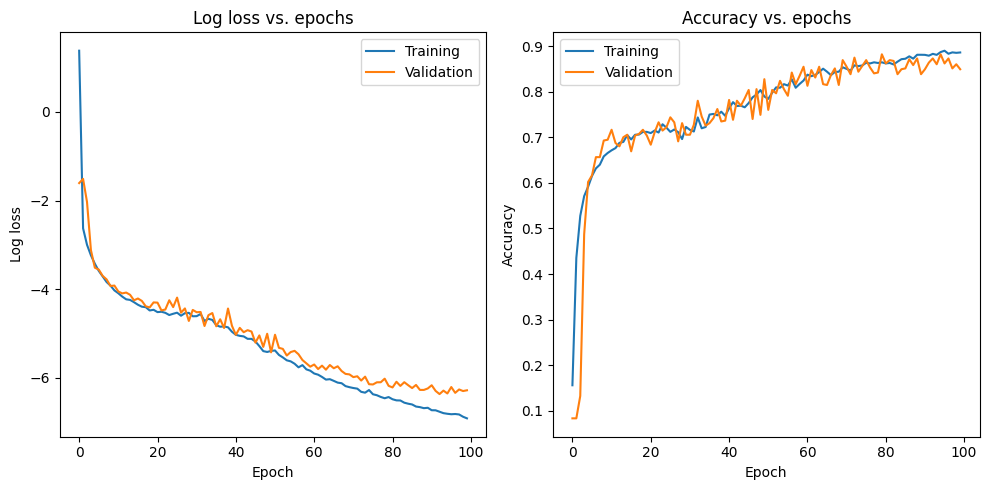

In [22]:
fig,ax=plt.subplots(1,2, figsize=(10, 5))

ax[0].plot(np.log(history['loss']),label='Training')
ax[0].plot(np.log(history['val_loss']),label= 'Validation')
ax[0].set_title('Log loss vs. epochs')
ax[0].set(ylabel='Log loss',xlabel='Epoch')
ax[0].legend( loc='best')


ax[1].plot(history['acc'],label='Training')
ax[1].plot(history['val_acc'],label= 'Validation')
ax[1].set_title('Accuracy vs. epochs')
ax[1].set(ylabel='Accuracy',xlabel='Epoch')
ax[1].legend(loc='best')


fig.tight_layout()
plt.show()

## testing on unseen data

In [38]:

data_test = tifffile.imread('test_z4_z15_0.5.tif')
data_test = process_images(data_test)
target_test = np.load('test_z4_z15_0.5.npy')

# Reshape target_test to (12, 36) and fill with zeros
new_target_test = np.zeros((target_test.shape[0], 36))
new_target_test[:, :target_test.shape[1]] = target_test

target_test = new_target_test

print(target_test.shape) # verify the new shape

(12, 36)


In [39]:
model_l = build_resnet_model(data_test.shape[1:], target_test.shape[1])
model_l.load_weights('best_weights.weights.h5')

In [40]:
y_predict=model_l.predict(data_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step


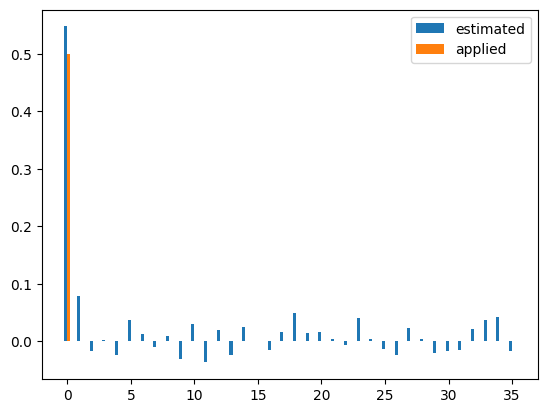

In [41]:
plt.bar(np.arange(len(y_predict[0]))-0.12,y_predict[0], label='estimated' , width = 0.24)
plt.bar(np.arange(len(target_test[0]))+0.12,target_test[0],label='applied', width = 0.24)
plt.legend()

In [42]:
def RMSE(target,predict):
  MSE = np.square(np.subtract(target,predict)).mean()
  RMSE = np.sqrt(MSE)
  return RMSE


In [44]:

rmse_values = []
for i in range(12):
  rmse = RMSE(target_test[i], y_predict[i])
  rmse_values.append(rmse)


In [45]:
rmse_values

[0.0274487152896151,
 0.02753284054972886,
 0.024933470419768167,
 0.019944796450328952,
 0.023617436892800284,
 0.027524852634120144,
 0.028781810833594188,
 0.02900535585159063,
 0.029383533128304423,
 0.027865599793274475,
 0.02560828895934854,
 0.030714121027524664]

(0.0, 0.5)

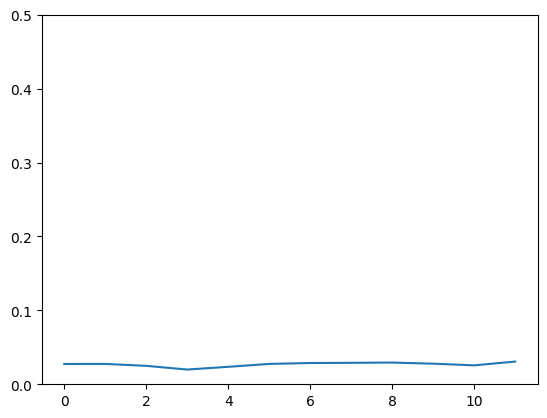

In [46]:
plt.plot(rmse_values)
plt.ylim(0, 0.5)